# context

Project is attempting to reproduce and reanalyse null tests performed in stage III shear catalogs. We are attempting to reproduce a test in HSC found in Hamana et. al 2019 figures 19,20. <br> Our results from txpipe are such that we are obtaining a significantly larger result than what was published (in fig 20). <br> We are not sure where the issue lies or where our choices may deviate from the procedure employed in that paper.

# reproducing the issue here:

The catalogs for the stars and galaxies were obtained via ___________. We used the following script to query the data:

In [ ]:
# script here:

We write a function to load each catalog here:

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_stars():
    with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy1/star_catalog_hscy1_allfields.h5","r") as f:
        g      = f["stars"]
        ra     = g["ra"][:]
        dec    = g["dec"][:]
        e1psf  = g["measured_e1"][:]
        e2psf  = g["measured_e2"][:]
        e1mod  = g["model_e1"][:]
        e2mod  = g["model_e2"][:]
        T_frac =(g["measured_T"][:] - g["model_T"][:]) / g["measured_T"][:]
        de1    = e1psf - e1mod
        de2    = e2psf - e2mod
        e_psf  = np.array((e1psf, e2psf))
        e_mod  = np.array((e1mod,e2mod))
        de_psf = np.array((de1, de2))
        del e1mod, e2mod, e1psf, e2psf, de1,de2
    f.close()

    return ra, dec, e_psf, e_mod, de_psf, T_frac

In [3]:
def load_galaxies():

    with h5py.File("/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hscy1/shear_cat_FULLCAT.h5","r") as f:
        ra = f["shear/ra"][:]
        dec = f["shear/dec"][:]
        g1 = f["shear/g1"][:]
        g2 = f["shear/g2"][:]
        weight = f["shear/weight"][:]
    f.close()

    return ra, dec, g1, g2, weight

Our rowe calculation is as follows:

In [ ]:
# rowe calculation

In [39]:
def compute_rowe(i, ra, dec, q1, q2):
    # select a subset of the stars
    n = len(ra)
    print(f"Computing Rowe statistic rho_{i} from {n} objects")
    import treecorr

    corr = treecorr.GGCorrelation(min_sep       = 0.9,
                                  max_sep       = 110,
                                  nbins         = 21,
                                  bin_slop      = 0.01,
                                  sep_units     = "arcmin",
                                  var_method    = "jackknife")
    cat1 = treecorr.Catalog(
        ra=ra, dec=dec, g1=q1[0], g2=q1[1], ra_units="deg", dec_units="deg", npatch=150)

    cat2 = treecorr.Catalog(
        ra=ra, dec=dec, g1=q2[0], g2=q2[1], ra_units="deg", dec_units="deg", patch_centers=cat1.patch_centers)

    corr.process(cat1, cat2)
    return corr.meanr, corr.xip, corr.varxip**0.5

In [4]:
ra, dec, e_psf, e_mod, de_psf, T_f = load_stars()

In [46]:
rowe_stats = {}
rowe_stats[0] = compute_rowe(0, ra, dec, e_mod, e_mod)
rowe_stats[1] = compute_rowe(1, ra, dec, de_psf, de_psf)
rowe_stats[2] = compute_rowe(2, ra, dec, e_mod, de_psf)#de_psf, e_mod)
# the below stats are not used for comparison
#rowe_stats[3] = compute_rowe(3, ra, dec, e_psf * T_f, e_psf * T_f)
#rowe_stats[4] = compute_rowe(4, ra, dec, de_psf, e_psf * T_f)
#rowe_stats[5] = compute_rowe(5, ra, dec, e_mod, e_psf * T_f)

Computing Rowe statistic rho_0 from 922355 objects
Computing Rowe statistic rho_1 from 922355 objects
Computing Rowe statistic rho_2 from 922355 objects


Plotted in comparison to Hamana et al 2019 figure 20. <br> We do not have access to a file with the stored measurements, therefore we create a new axis with an image of the published results and overplot our measurement, taking care to match the x,y limits and binning. |

In [ ]:
# plot

In [36]:
np.shape(rowe_stats[0])

(3, 20)

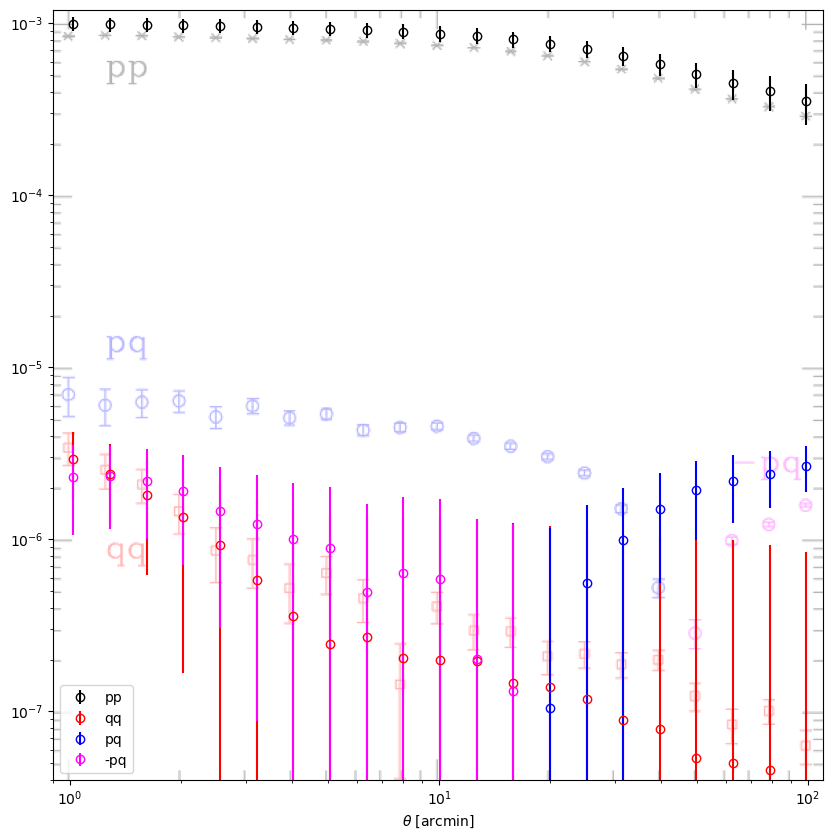

In [47]:
#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/rowe_012.png")
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_ylim([4e-8,1.2e-3])
newax.set_xlim([0.9,110])
newax.set_xlabel(r'$\theta$ [arcmin]')
newax.set_xscale('log')
newax.set_yscale('log')

#Change formatting of xticks
#newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

plt.errorbar(rowe_stats[0][0],rowe_stats[0][1],rowe_stats[0][2],linestyle='None',marker='o',mfc='None',color='black',label='pp')
plt.errorbar(rowe_stats[1][0],rowe_stats[1][1],rowe_stats[2][2],linestyle='None',marker='o',mfc='None',color='red',label='qq')
plt.errorbar(rowe_stats[2][0][rowe_stats[2][1]>0],rowe_stats[2][1][rowe_stats[2][1]>0],rowe_stats[2][2][rowe_stats[2][1]>0],linestyle='None',marker='o',mfc='None',color='blue',label='pq')
plt.errorbar(rowe_stats[2][0][rowe_stats[2][1]<0],-1*rowe_stats[2][1][rowe_stats[2][1]<0],rowe_stats[2][2][rowe_stats[2][1]<0],linestyle='None',marker='o',mfc='None',color='fuchsia',label='-pq')

plt.legend()
plt.show()

Moving onto the other measurement, we calculate the statistic in the following way:

In [ ]:
# tau calc

In [5]:
def compute_all_tau(gra, gdec, g, gw, sra, sdec, e_mod, de_psf,meansub=True):
    '''
    Compute tau0, tau2
    Both need to be computed at once due to covariance.
    gra    : RA of galaxies
    gdec   : DEC of galaxies
    g      : shear for observed galaxies np.array((e1, e2))
    gw     : weights

    sra    : RA of stars
    sdec   : DEC of stars

    e_mod  : model ellipticities of PSF               -- np.array((e1mod, e2mod))
    de_psf : e_psf-e_mod                              -- np.array((e1psf, e2psf))
    '''

    import treecorr
    print("starting tau calculation...")
    p = e_mod
    q = de_psf

    sra, sdec = np.array((sra, sdec)) # Get ra/dec for specific stars
    p = np.array(( [p[0], p[1]]))     # Get p for specific stars
    q = np.array(( [q[0], q[1]]))     # Get q for specific stars

    
    # Load all catalogs
    if meansub != True:
        catg = treecorr.Catalog(ra=gra, dec=gdec, g1=g[0], g2=g[1], w=gw, ra_units="deg", dec_units="deg",npatch=150) # galaxy shear
        catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0], g2=p[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
        catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0], g2=q[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
        del p, q

    else:
        mg = [np.mean(g[0]),np.mean(g[1])]
        mp = [np.mean(p[0]),np.mean(p[1])]
        mq = [np.mean(q[0]),np.mean(q[1])]
        catg = treecorr.Catalog(ra=gra, dec=gdec, g1=g[0]-mg[0], g2=g[1]-mg[1], w=gw, ra_units="deg", dec_units="deg",npatch=150) # galaxy shear
        catp = treecorr.Catalog(ra=sra, dec=sdec, g1=p[0]-mp[0], g2=p[1]-mp[0], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # e_model
        catq = treecorr.Catalog(ra=sra, dec=sdec, g1=q[0]-mq[0], g2=q[1]-mq[1], ra_units="deg", dec_units="deg",patch_centers=catg.patch_centers) # (e_* - e_model)
        del p, q, mg, mp, mq
    
    # Compute all corrleations
    corr0 = treecorr.GGCorrelation(min_sep       = 3,
                                   max_sep       = 110.0,
                                   nbins         = 16,
                                   bin_slop      = 0.01,
                                   sep_units     = "arcmin")
    corr0.process(catg, catp)
    corr2 = treecorr.GGCorrelation(min_sep       = 3,
                                   max_sep       = 110.0,
                                   nbins         = 16,
                                   bin_slop      = 0.01,
                                   sep_units     = "arcmin")
    corr2.process(catg, catq)

    del catg, catp, catq,  
    # Estimate covariance using bootstrap. The ordering is xip0,xim0,xip2,xim2
    cov = treecorr.estimate_multi_cov([corr0,corr2], method="jackknife")

    # For our particular purpose, we only care about xip so can remove the xim elements. 
    nbins = 16
    idx = [i + j for i in range(nbins, 4*nbins, nbins * 2) for j in range(nbins) if i + j < 4*nbins]
    cov = np.delete(cov,idx,axis=0)
    cov = np.delete(cov,idx,axis=1)
    return corr0.meanr, corr0.xip, corr2.xip, cov

Plotted in comparison to Hamana et. al 2019 figure 19.

In [6]:
gra, gdec, g1, g2, gw = load_galaxies()

In [7]:
g = [g1,g2]

tht, c0, c2, cov = compute_all_tau(gra, gdec, g, gw, ra, dec, e_mod, de_psf)


starting tau calculation...


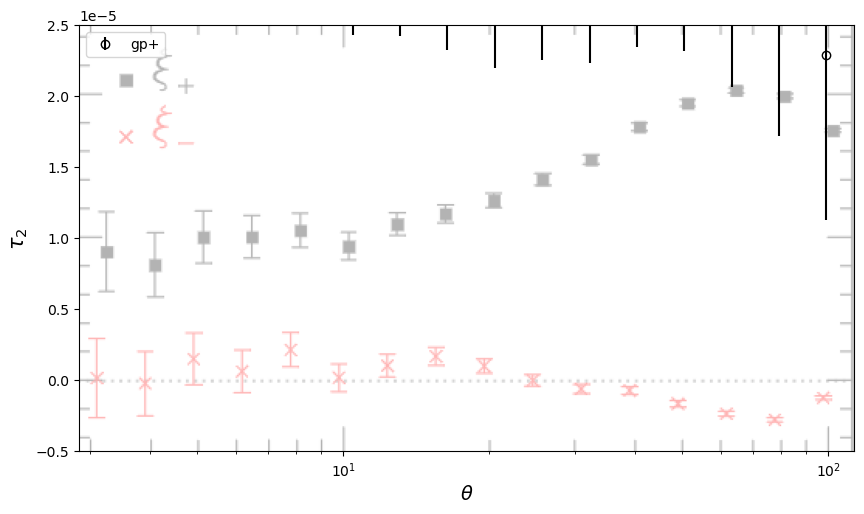

In [27]:
# plot

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gp.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht,c0,np.diag(cov[int(0*nbins):int(1*nbins),int(0*nbins):int(1*nbins)])**0.5,linestyle='None',marker='o',mfc='None',color='black',label='gp+')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()

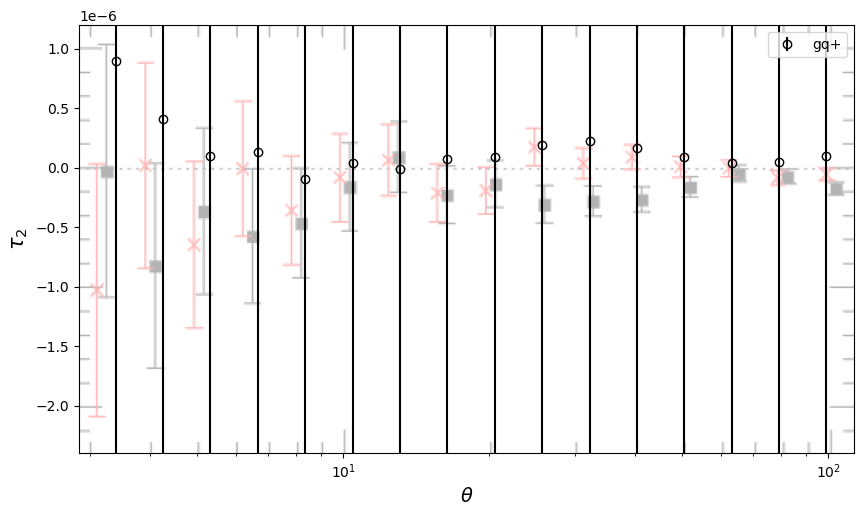

In [29]:

#set first axes
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("Hamana2019/Xi_gq.png")

ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_xlim((2.85,113))

newax.set_ylim((-2.4e-6,1.2e-6))
newax.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
newax.set_ylabel(r'$\tau_{0+}$',size=15)
newax.set_xscale('log')
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
nbins=16
plt.errorbar(tht,c2,np.diag(cov[int(0*nbins):int(1*nbins),int(0*nbins):int(1*nbins)])**0.5,linestyle='None',marker='o',mfc='None',color='black',label='gq+')
plt.xscale('log')
plt.ylabel(r'$\tau_2$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.show()